# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 

## Importing Packages

In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings("ignore")

C:\Users\sowmi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [3]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [4]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [5]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


In [6]:
df.head()

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241


<Axes: xlabel='category'>

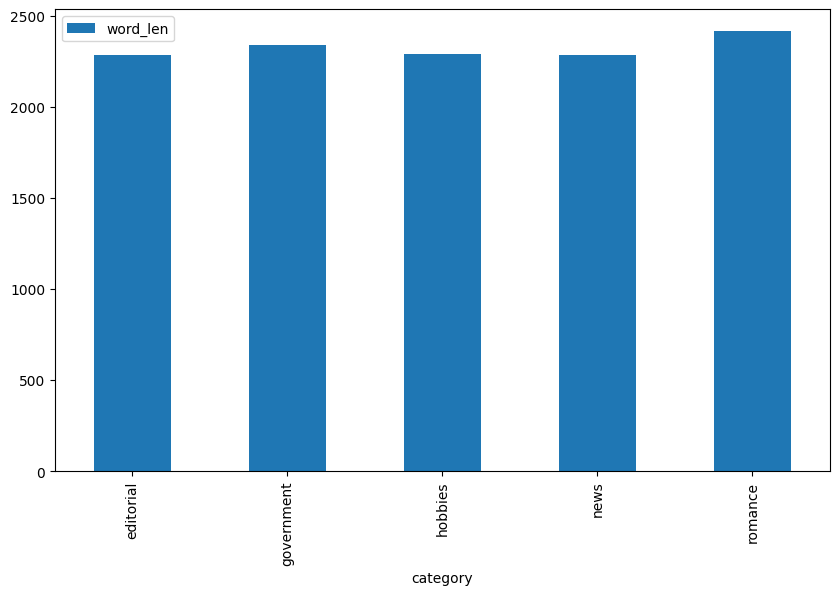

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords),  # removes stopwords
                                        min_df=5,                    # removes words less than this threshold
                                        max_df=0.7)                  # removes words that appears over 70%

count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [9]:
type(count_text_vectors)

scipy.sparse._csr.csr_matrix

In [10]:
# Get the feature names
count_feature_names = count_text_vectorizer.get_feature_names_out()

# Convert sparse matrix into a dataframe
count_text_vectors_df = pd.DataFrame.sparse.from_spmatrix(count_text_vectors, columns=count_feature_names)
count_text_vectors_df.head()

,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
0,0,3,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,3,0,0,0,1,0,1,0,0,...,0,0,0,3,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,0,1,0,0,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [12]:
# Get the feature names
tfidf_feature_names = tfidf_text_vectorizer.get_feature_names_out()

# Convert sparse matrix into a dataframe
tfidf_text_vectors_df = pd.DataFrame.sparse.from_spmatrix(tfidf_text_vectors, columns=tfidf_feature_names)
tfidf_text_vectors_df.head()

,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
0,0,0.046852,0,0,0,0,0,0.02345,0,0.019456,...,0,0,0,0.016895,0,0,0,0,0,0
1,0,0.040107,0,0,0,0.015896,0,0.020074,0,0,...,0,0,0,0.043389,0,0,0,0,0.062348,0
2,0,0,0,0.041794,0,0,0,0,0,0,...,0,0,0,0,0.034956,0,0,0,0,0
3,0,0.016735,0,0,0,0.039797,0,0,0,0.020849,...,0,0,0.036429,0,0,0,0,0,0,0
4,0,0.014687,0,0.018843,0.019635,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?**

A: The data frames contain unique words from each article, with words represented as columns (4941) and each row (166 rows) corresponding to an article. The count_text_vectors_df stores the frequency of each word in the respective article, while the tfidf_text_vectors_df holds the TF-IDF values, which measure the significance of words within the corpus. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [13]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [14]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [15]:
# dataframe to hold NMF predicted topics and original categories
nmf_topics_df = pd.DataFrame()
nmf_topics_df['original_category'] = df['category']

# Dominant topic in each document
nmf_topics_df['predicted_topic'] = np.argmax(W_text_matrix, axis=1)
nmf_topics_df.head()

,original_category,predicted_topic
0,editorial,2
1,editorial,0
2,editorial,0
3,editorial,0
4,editorial,0


In [16]:
# Tally the categories for each topic
nmf_topics_df.groupby(['predicted_topic', 'original_category']).size()

predicted_topic  original_category
0                editorial            20
                 government            4
                 news                  8
1                editorial             4
                 hobbies               8
                 romance              29
2                editorial             2
                 government           26
                 hobbies              26
                 news                 11
3                hobbies               1
                 news                 17
4                editorial             1
                 hobbies               1
                 news                  8
dtype: int64

**Q: How does your five-topic NMF model compare to the original Brown categories?**

A: The five-topic NMF model largely matches the original Brown categories but some misclassifications indicate that the model falls short of accurately capturing the distinct categories within the Brown corpus.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [17]:
# Fitting LSA model
svd_text_model = TruncatedSVD(n_components=5, random_state=314)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [18]:
# dataframe to hold predicted topics and original categories
lsa_topics_df = pd.DataFrame()
lsa_topics_df['original_category'] = df['category']

# Dominant topic in each document
lsa_topics_df['predicted_topic'] = np.argmax(W_svd_text_matrix, axis=1)
lsa_topics_df.head()

,original_category,predicted_topic
0,editorial,0
1,editorial,0
2,editorial,0
3,editorial,0
4,editorial,0


In [19]:
# Tally the categories for each topic
lsa_topics_df.groupby(['predicted_topic', 'original_category']).size()

predicted_topic  original_category
0                editorial            27
                 government           30
                 hobbies              36
                 news                 34
                 romance              21
1                romance               8
3                news                  3
4                news                  7
dtype: int64

**Q: How does your five-topic LSA model compare to the original Brown categories?**

A: The five-topic LSA model does not align well with the original Brown categories, as multiple categories are mixed within each predicted topic. For example, Topic 0 includes a variety of categories, suggesting that the LSA model groups documents from different original categories together, lacking clear topic differentiation.

In [20]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


**Q: What is your interpretation of the display topics output?** 

A: The display topics output reveals an overview of the primary themes associated with each topic, highlighting the terms and their corresponding weights. For instance, Topic 00 includes general terms such as "said", "mr" and "mrs" related to conversations between people. Topic 04 features terms like "game," "league," and "baseball," indicating a focus on sports-related themes. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [21]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [22]:
# dataframe to hold predicted topics and original categories
lda_topics_df = pd.DataFrame()
lda_topics_df['original_category'] = df['category']

# Dominant topic in each document
lda_topics_df['predicted_topic'] = np.argmax(W_lda_text_matrix, axis=1)
lda_topics_df.head()

,original_category,predicted_topic
0,editorial,2
1,editorial,2
2,editorial,2
3,editorial,2
4,editorial,2


In [23]:
# Tally the categories for each topic
lda_topics_df.groupby(['predicted_topic', 'original_category']).size()

predicted_topic  original_category
0                editorial             3
                 government            1
                 hobbies              11
                 news                  4
                 romance              28
1                editorial             1
                 government           12
                 hobbies               9
                 news                  3
2                editorial            21
                 government            3
                 hobbies               2
                 news                 32
                 romance               1
3                editorial             2
                 government            4
                 hobbies               8
                 news                  3
4                government           10
                 hobbies               6
                 news                  2
dtype: int64

In [24]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


**Q: What inference do you draw from the displayed topics for your LDA model?** 

A: The topics displayed by the LDA model show clear thematic patterns, with each topic representing a specific theme through its associated terms. For example, Topic 02 features terms like "president," "state," and "city," indicating a focus on political discourse.

**Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?**

A: The LDA model aligns some topics with the original Brown categories, but there is considerable overlap between categories across different topics. This indicates that the model has difficulty fully distinguishing the thematic boundaries within the Brown corpus.

In [25]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [26]:
pyLDAvis.display(lda_display)

**Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.**

A: In the principal component analysis (PCA) diagram, the size of each bubble reflects the prevalence of the topic within the corpus. Topic 3 has a larger bubble compared to the other topics, indicating that it occurs more frequently among the Brown categories. Topics 1 and 3 are positioned close together, suggesting some overlap in the terms they capture. In contrast, Topics 2 and 4 appear to represent more distinct themes, as they are positioned farther away from the other bubbles.

On the right side, the graph displays the 30 most salient terms for each topic. The blue bars represent the overall frequency of each term across the entire corpus, while the red bars show the contribution of each word to the currently selected topic. In Topic 3, the red bar for the term "said" is significantly longer than for other terms, indicating the particular importance of this word in that topic. In the other topics, the red bars do not decrease rapidly, suggesting that the terms are more evenly distributed across the corpus.
